<a href="https://colab.research.google.com/github/Mt-river/Timetable-SNU-Musikverein/blob/main/DL_day11/11_1_time_series_prediction_with_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with Transformer

You will now practice using Transformer to predict future values using past values. For your assignment, please change parameters, model structures and apply new model to shampoo data.

Reference:
* https://github.com/hee9joon/Univariate-Time-Series-Prediction-using-Deep-Learning.   
*  https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## Download Dataset

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2025-08-28 02:27:28--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2025-08-28 02:27:28 (13.5 MB/s) - ‘shampoo.csv’ saved [519/519]



In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-08-28 02:27:39--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-08-28 02:27:39 (37.9 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

## Data Plot

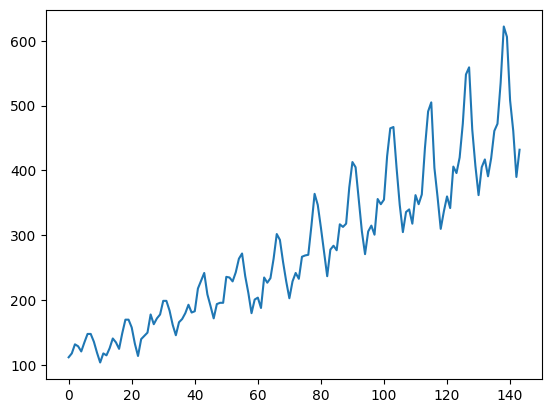

In [4]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [5]:
sc = StandardScaler()
seq_length = 4

test_size = 20
train_size = len(training_set) - seq_length - 20

train_data = sc.fit_transform(training_set[:-test_size])
test_data = sc.transform(training_set[-test_size:])

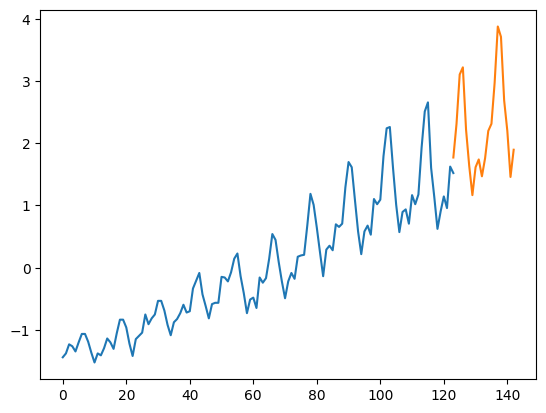

In [6]:
plt.plot(np.arange(124),train_data)
plt.plot(np.arange(20)+123,test_data)
plt.show()

In [7]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [8]:
normalized_data = np.concatenate([train_data, test_data])
x, y = sliding_windows(normalized_data, seq_length)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:-test_size])))
trainY = Variable(torch.Tensor(np.array(y[:-test_size])))

testX = Variable(torch.Tensor(np.array(x[-test_size:])))
testY = Variable(torch.Tensor(np.array(y[-test_size:])))

## Model

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        d_h = d_model // n_heads

        self.scale = d_h**-0.5
        self.n_heads, self.d_h = n_heads, d_h

        self.W_Q = nn.Linear(d_model, d_h * n_heads)
        self.W_K = nn.Linear(d_model, d_h * n_heads)
        self.W_V = nn.Linear(d_model, d_h * n_heads)

        self.to_out = nn.Linear(n_heads * d_h, d_model)

    def forward(self, q, k, v):

        bs = q.size(0)
        # Linear (+ split in multiple heads)
        q_s = self.W_Q(q).view(bs, -1, self.n_heads, self.d_h)
        k_s = self.W_K(k).view(bs, -1, self.n_heads, self.d_h)
        v_s = self.W_V(v).view(bs, -1, self.n_heads, self.d_h)

        attn_scores = torch.einsum('bphd, bshd -> bphs', q_s, k_s) * self.scale

        attn_weights = F.softmax(attn_scores, dim=-1)

        output = torch.einsum('bphs, bshd -> bphd', attn_weights, v_s)
        output = output.contiguous().view(bs, -1, self.n_heads*self.d_h)
        output = self.to_out(output)

        return output

class EncoderBlock(nn.Module):
    def __init__(self, input_dim):
        super(EncoderBlock, self).__init__()
        self.input_dim = input_dim

        self.ffn = nn.Sequential(nn.Linear(self.input_dim, 2*self.input_dim),
                        nn.GELU(),
                        nn.Dropout(0.2),
                        nn.Linear(2*self.input_dim, self.input_dim))

        self.layernorm = nn.LayerNorm(self.input_dim)
        self.dropout = nn.Dropout(0.2)
        self.attn = AttentionBlock(self.input_dim, 2)

    def forward(self, x):

        y = self.attn(x,x,x)
        x = x + self.dropout(y)
        x = self.layernorm(x)

        y = self.ffn(x)
        x = x + self.dropout(y)
        y = self.layernorm(x)

        return y

class Transformer(nn.Module):
    def __init__(self, input_dim, emb_dim, out_dim, num_encoder):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.input_layer = nn.Linear(input_dim//2, emb_dim//2, bias=True)
        self.encoder_layers = nn.ModuleList([])
        for i in range(num_encoder):
            self.encoder_layers.append(EncoderBlock(emb_dim//2))
            #self.encoder_layers.append(nn.TransformerEncoderLayer(d_model=emb_dim//2, nhead=2,dim_feedforward=emb_dim, dropout=0.2, activation="gelu"))
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(emb_dim, out_dim, bias=True)
    def forward(self, x):
        # x: [120,4] 120: batch_size, 4: input_dim
        mean = x.mean(dim=1,keepdim=True)
        std = x.std(dim=1,keepdim=True)
        x = (x-mean)/std
        x = x.reshape(-1, 2, self.input_dim//2) ## Transformer는 Batch를 제외하고 2차원의 Input이 필요하기 때문에 변형.
        # x: [120,2,2]
        x = self.input_layer(x)
        # x: [120,2,8]
        for l in self.encoder_layers:
            x = l(x)
        # x: [120,2,8]
        x = self.flatten(x)
        # x: [120,16]
        x = self.output_layer(x)
        # x: [120,1] 1: out_dim
        x = x*std+mean
        return x

## Training

In [10]:
fix_seed = 42
import random
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

num_epochs = 5000
learning_rate = 0.0001

input_size = 4
embed_size = 16
num_layers = 3

output_size = 1

best_loss = 10
best_model = None

model = Transformer(input_size, embed_size, output_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX[:,:,0])
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 50 == 0:
      model.eval()
      outputs = model(testX[:,:,0])
      loss = criterion(outputs, testY)
      model.train()
      if loss.item()<best_loss:
        best_loss = loss.item()
        best_model = model
      if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 1.12045
Epoch: 500, loss: 0.30786
Epoch: 1000, loss: 0.22581
Epoch: 1500, loss: 0.17188
Epoch: 2000, loss: 0.14843
Epoch: 2500, loss: 0.13615
Epoch: 3000, loss: 0.13426
Epoch: 3500, loss: 0.13690
Epoch: 4000, loss: 0.14156
Epoch: 4500, loss: 0.14611


## Testing for Airplane Passengers Dataset

Best Loss: 0.1319984644651413


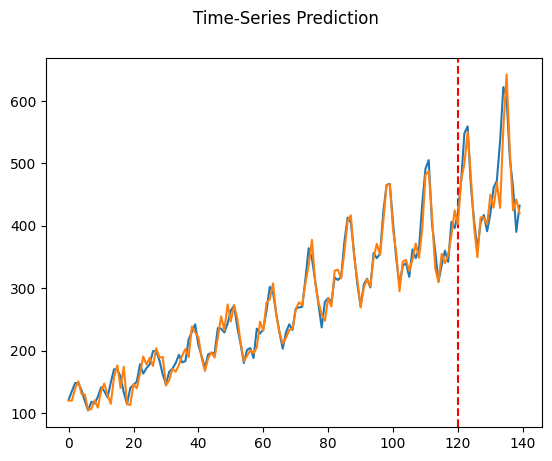

In [11]:
best_model.eval()
train_predict = best_model(dataX[:,:,0])

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

print("Best Loss: {}".format(best_loss))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()